# TODO  
## Write C functions (tv_denoise, tv_denoise_core, tv_denoise_core_org)  
## Understand the difference between tv_denoise_core, tv_denoise_core_org  
## Add legends to the pics
## ...

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib
# import visvis as vv
%matplotlib inline

In [2]:
def ddot_(vector_a, vector_b):
    if len(vector_a) != len(vector_b):
        raise Exception('Dimention of vectors is not equal')
    return np.dot(vector_a, vector_b)

In [3]:
ddot_([1, 2, 3], [1, 1, 1])

6

In [4]:
def dnrm2_(vector):
    return np.linalg.norm(vector)

In [5]:
dnrm2_(np.array([1, 2, 3]))

3.7416573867739413

In [6]:
def daxpy_(vector_a, vector_b, alpha):
    vector_a = alpha * np.array(vector_b) + np.array(vector_a)
    return vector_a

In [7]:
daxpy_([1, 2, 3], [1, 1, 1], 2)

array([3, 4, 5])

# Some funcs from tools.c that we use (done)

In [115]:
"""
double ddot_(int *p_n, double *p_x, int *incx, double *p_y, int *incy)
{
     register int i, n;
     register double *x, *y;
     register double ddot = 0;
     x = p_x;
     y = p_y;
     n = *p_n;
     for (i = 0; i < n; ++i)
          ddot += (*x++)*(*y++);

     return ddot;
}

double dnrm2_(int *p_n, double *p_x, int *incx)
{
	register int i,n;
	register double *x;
	register double nrm2 = 0;
	
	x = p_x;
	n = *p_n;

	for (i = 0; i < n; ++i){
			nrm2 += (*x)*(*x);
			x++; 
	}

	return sqrt(nrm2);
}

/* Only implements the simplest version of daxpy which is used in this code 
   here, with incrx and incry = 1 hardcoded. *y points at the results (overwrite) */
void daxpy_(int *p_n, double *p_alpha, double *p_x, int *incx, double *p_y, int *incy)
{
	   register int i, n;
     register double *x, *y,alpha;
     x = p_x;
     y = p_y;
     n = *p_n;
		 alpha = *p_alpha;

     for (i = 0; i < n; ++i){
          *y = alpha*(*x) + (*y);
					y++;x++;
		 }
}

"""

'\ndouble ddot_(int *p_n, double *p_x, int *incx, double *p_y, int *incy)\n{\n     register int i, n;\n     register double *x, *y;\n     register double ddot = 0;\n     x = p_x;\n     y = p_y;\n     n = *p_n;\n     for (i = 0; i < n; ++i)\n          ddot += (*x++)*(*y++);\n\n     return ddot;\n}\n\ndouble dnrm2_(int *p_n, double *p_x, int *incx)\n{\n\tregister int i,n;\n\tregister double *x;\n\tregister double nrm2 = 0;\n\t\n\tx = p_x;\n\tn = *p_n;\n\n\tfor (i = 0; i < n; ++i){\n\t\t\tnrm2 += (*x)*(*x);\n\t\t\tx++; \n\t}\n\n\treturn sqrt(nrm2);\n}\n\n/* Only implements the simplest version of daxpy which is used in this code \n   here, with incrx and incry = 1 hardcoded. *y points at the results (overwrite) */\nvoid daxpy_(int *p_n, double *p_alpha, double *p_x, int *incx, double *p_y, int *incy)\n{\n\t   register int i, n;\n     register double *x, *y,alpha;\n     x = p_x;\n     y = p_y;\n     n = *p_n;\n\t\t alpha = *p_alpha;\n\n     for (i = 0; i < n; ++i){\n          *y = alpha*(*

In [8]:
def tv_denoise():
    pass

In [122]:
#matlab function
def TVdenoise(noisy_image, delta, eps_rel = 10e-3):
    """
    noisy image - np array !!!
    delta = tau * sqrt(M * N) * sigma
        -tau - less than 1 (0.85 in paper)
        -M, N - size of immage
        -sigma - std of the noise in the pixel
    eps_rel - relative accuracy 1e-3 by default
    """
    alpha = np.sum(noisy_image.flatten()) / len(noisy_image)
    X = alpha * np.ones(noisy_image.shape)
    mdelta = np.linalg.norm(X - noisy_image, 'fro')
    if mdelta < delta:
        #maybe put some info here like in paper
        return
    elif mdelta < 1.1 * delta:
        #maybe throw warning like in paper
        print('Convergence problems may arise')
    R = max(noisy_image.flatten())
    mn = noisy_image.shape[0] * noisy_image.shape[1]
    epsilon = R * mn * eps_rel
    mu = epsilon / mn
    Lmu = 8 / mu
    N = np.ceil(2 * np.sqrt(8 * mn) * delta / epsilon).astype(int) # maxiter as far as I understood
    X,k,epsilon_k = tv_denoise(noisy_image, delta, epsilon, Lmu, mu, N, 0) # rewrite C func!!!!

# TVdenoise main part in Matlab is done but C function has to be written!!

In [114]:
"""
function [X,info] = TVdenoise(B,delta,eps_rel)
%TVDENOISE  Total variation image denoising
% 
% X = TVdenoise(B,delta)
% [X,info] = TVdenoise(B,delta,eps_rel)
%
% This function solves the TV denoising problem
%
%    min  TV(X)  subject to   || X - B ||_F <= delta
%
% where B is a noisy image, X is the reconstruction, and delta is an
% upper bound for the residual norm.  The TV function is the 1-norm
% of the gradient magnitude, computed via neighbor pixel differences.
% At the image borders, we imposed reflexive boundary conditions for
% the gradient computations.
%
% The parameter delta should be of the same size as the norm of the
% image noise.  If the image is m-times-n, and sigma is the standard
% deviation of the image noise in a pixel, then we recommend to use
% delta = tau*sqrt(m*n)*sigma, where tau is slightly smaller than one,
% say, tau = 0.85.
%
% The function returns an epsilon-optimal solution X, meaning that
% if X* is the exact solution, then our solution X satisfies
%
%     TV(X) - TV(X*) <= epsilon = max(B(:))*m*n*eps_rel,
%
% where eps_rel is a specified relative accuracy (default eps_rel = 1e-3).
% 
% The solution status is returned in the stuct info, with info.STATUS
% having one of the settings
%  'EPSILON-OPTIMAL-SOLUTION': X is an epsilon-optimal solution
%  'NOT-EPSILON-OPTIMAL-SOLUTION': X is not an epsilon-optimal solution
%  'MAXIMUM-NUMBER-OF-ITERATIONS-EXCEEDED': X is not an epsilon-optimal
%     solution when the maximum number of iterations was reached. 
% Other fields of info:
%  info.NDENOISE      Upper bound for the number of iterations.
%  info.ITERATIONS_K  The number of iterations used.	
%  info.EPS_REL_K     The relative accuracy reached.
%  info.TIME          Time in seconds for the program to run. 
%
% See also: TVdeblur, TVinpaint.

% J. Dahl^1, P.C. Hansen^2, S.H. Jensen^1 & T.L. Jensen^1
% CSI project: (1) Aalborg University, (2)Technical University of Denmark
% April 28, 2009.

% Check input parameters.
if nargin < 2	
	error('Too few input parameters');
elseif nargin == 2
	eps_rel = 1e-3;
end
tic

% The special case where the solution is the constant image.
alpha = sum(B(:))/numel(B);
X = alpha*ones(size(B));
mdelta = norm(X-B,'fro');
if  mdelta < delta
    % The constant image is the solution.
    info = info_type_denoise(1,0,0,0,toc);
    return;
elseif mdelta < 1.1*delta
    % The constant image is almost a solution.
    warning('Convergence problems may arise')
end

% Set parameters for denoising algorithm.
R = max(B(:));
mn = numel(B);
epsilon = R*mn*eps_rel;
mu = epsilon/mn;
Lmu = 8/mu ;
N = int32( ceil(2*sqrt(8*mn)*delta/epsilon) );

% Compute TV solution via C function.
[X,k,epsilon_k] = tv_denoise(B,delta,epsilon,Lmu,mu,N,0);

% Set info, if required.
if nargout == 2
	if k >= N
	    info = info_type_denoise(3,N,k,epsilon_k/(R*mn),toc);
    elseif epsilon_k > epsilon
		info = info_type_denoise(2,N,k,epsilon_k/(R*mn),toc);
	else
		info = info_type_denoise(1,N,k,epsilon_k/(R*mn),toc);	
    end
end
"""

"\nfunction [X,info] = TVdenoise(B,delta,eps_rel)\n%TVDENOISE  Total variation image denoising\n% \n% X = TVdenoise(B,delta)\n% [X,info] = TVdenoise(B,delta,eps_rel)\n%\n% This function solves the TV denoising problem\n%\n%    min  TV(X)  subject to   || X - B ||_F <= delta\n%\n% where B is a noisy image, X is the reconstruction, and delta is an\n% upper bound for the residual norm.  The TV function is the 1-norm\n% of the gradient magnitude, computed via neighbor pixel differences.\n% At the image borders, we imposed reflexive boundary conditions for\n% the gradient computations.\n%\n% The parameter delta should be of the same size as the norm of the\n% image noise.  If the image is m-times-n, and sigma is the standard\n% deviation of the image noise in a pixel, then we recommend to use\n% delta = tau*sqrt(m*n)*sigma, where tau is slightly smaller than one,\n% say, tau = 0.85.\n%\n% The function returns an epsilon-optimal solution X, meaning that\n% if X* is the exact solution, then o

In [63]:
def read_image(path):# better to use pic from example (It returns matrix, not tensor)
    """
    Returns np.array like object (np.array functions work)
    """
    return imageio.imread(path)

In [64]:
image = read_image('Pirate.tif')

In [65]:
image.shape

(512, 512)

In [104]:
def create_noisy_image(image, noise_std):
    noisy_image = image + noise_std * np.random.randn(image.shape[0], image.shape[1])
    for row in range(noisy_image.shape[0]): # the larger picture the longer computations!
        for column in range(noisy_image.shape[1]):
            noisy_image[row][column] = max(noisy_image[row][column], 0) # clip outliers
            noisy_image[row][column] = min(noisy_image[row][column], 255)
    return noisy_image

In [105]:
def plot_image(image):
    plt.figure(figsize = (10, 10))
    plt.imshow(image)

In [106]:
noisy_image = create_noisy_image(image, 25)

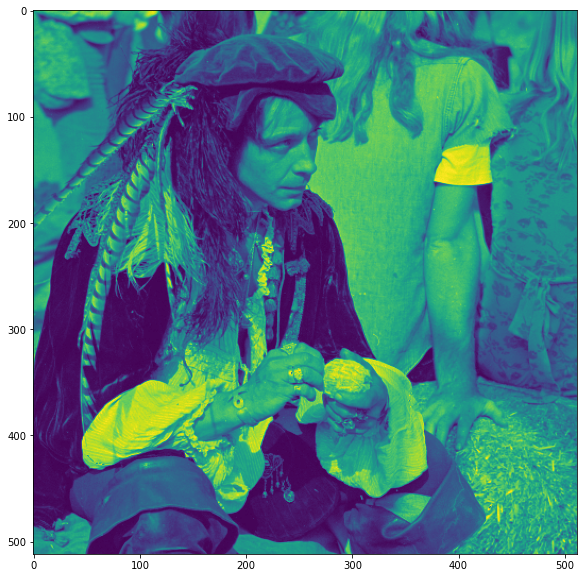

In [107]:
plot_image(image)

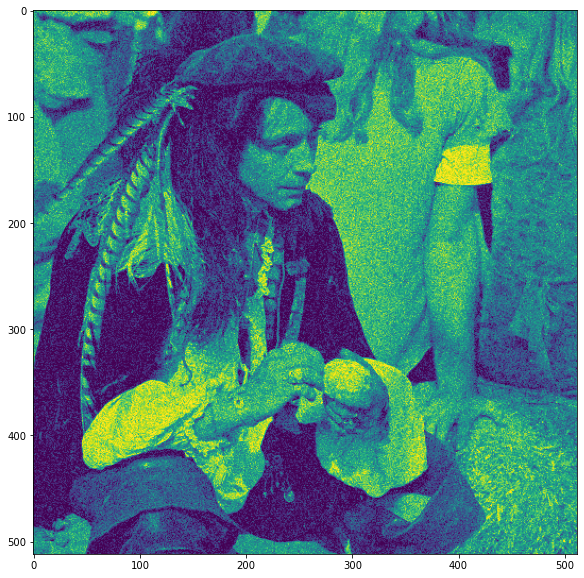

In [108]:
plot_image(noisy_image)

In [113]:
def TVdenoise_demo(image_path, noise_std, tau):
    image = read_image(image_path)
    create_noisy_image(image, noise_std)
    plot_image(image)
    plot_image(noisy_image)
    delta = tau * np.sqrt(noisy_image.shape[0] * noisy_image.shape[1]) * noise_std
    #denoised_image = TVdenoise(noisy_image, delta) # rewrite C func! may be add info parameter like in paper
    #actually TVdenoise is done, but it has C function insude, that should be rewritten
    #plot(denoised_image)

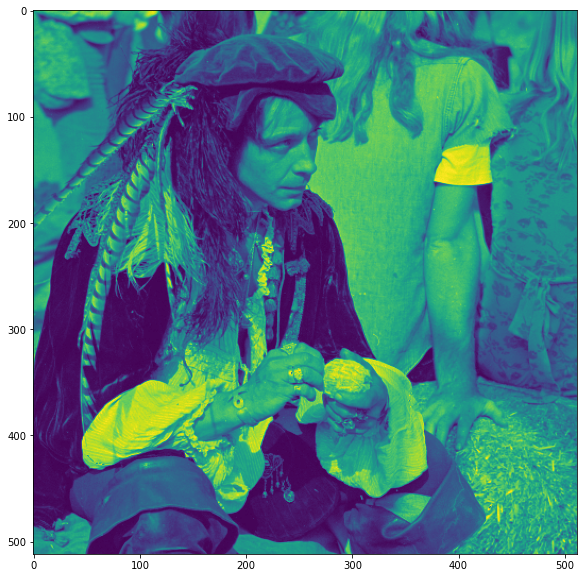

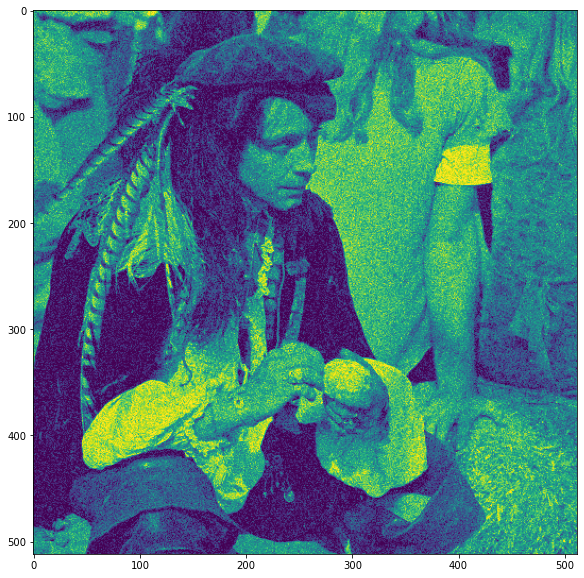

In [111]:
TVdenoise_demo('Pirate.tif', 25, 0.85) # add legends to  pictures!!!

# TVdenoise_demo matlab script from paper (done)

In [112]:
"""
%TVdenoise_demo  Demo script for TV denoising algorithm applied to EAR
%
% This script illustrates the use of the TV denoising algorithm
% implemented in the function TVdenoise; it produces Fig. 2 in the
% accompanying paper. The user can easily modify the script for
% other images and noise levels.
%
% The script loads a clean image and adds Gaussian noise, and then
% computes two TV reconstructions for two different values of tau.  Note
% that the computation of each TV reconstruction takes several seconds.

% J. Dahl^1, P.C. Hansen^2, S.H. Jensen^1 & T.L. Jensen^1
% CSI project: (1) Aalborg University, (2) Technical University of Denmark
% April 28, 2009.

clear, clc
close all
disp('Starting TVdenoise_demo')

% Set parameters.
im_name   = 'Pirate.tif';   % Name of clean image.
noise_std = 25;             % Standard deviation of image noise.
tau       = 0.85;           % Factor in residual bound.

% Load the clearn image and add Gaussian noise; make sure the pixels of the
% noisy image are in the range 0,...,255.
Xc = double(imread(im_name));
B = Xc + noise_std*randn(size(Xc));
B(B<0) = 0; B(B>255) = 255;

figure(1), clf, colormap(gray)
subplot(2,2,1)
  imagesc(Xc); axis image off
  title('Original clean image')
subplot(2,2,2)
  imagesc(B), axis image off
  title('Noisy image');
    
% Set the residual bound delta, and compute reconstruction.
disp(['Computing TV reconstruction for tau = ',num2str(tau),...
      ', this takes several seconds ...'])
delta = tau*sqrt(numel(B))*noise_std;
[X,info1] = TVdenoise(B,delta);

subplot(2,2,3)
  imagesc(X); axis image off
  title(['TV denoised image,  \tau = ',num2str(tau)])
      
% Also try a larger value of tau.
tau = 1.2;
disp(['Computing TV reconstruction for tau = ',num2str(tau),...
      ', this takes even longer ...'])
delta =  tau*sqrt(numel(B))*noise_std;
[XX,info2] = TVdenoise(B,delta);

subplot(2,2,4)
  imagesc(XX); axis image off
  title(['TV denoised image,  \tau = ',num2str(tau)])
"""

"\n%TVdenoise_demo  Demo script for TV denoising algorithm applied to EAR\n%\n% This script illustrates the use of the TV denoising algorithm\n% implemented in the function TVdenoise; it produces Fig. 2 in the\n% accompanying paper. The user can easily modify the script for\n% other images and noise levels.\n%\n% The script loads a clean image and adds Gaussian noise, and then\n% computes two TV reconstructions for two different values of tau.  Note\n% that the computation of each TV reconstruction takes several seconds.\n\n% J. Dahl^1, P.C. Hansen^2, S.H. Jensen^1 & T.L. Jensen^1\n% CSI project: (1) Aalborg University, (2) Technical University of Denmark\n% April 28, 2009.\n\nclear, clc\nclose all\ndisp('Starting TVdenoise_demo')\n\n% Set parameters.\nim_name   = 'Pirate.tif';   % Name of clean image.\nnoise_std = 25;             % Standard deviation of image noise.\ntau       = 0.85;           % Factor in residual bound.\n\n% Load the clearn image and add Gaussian noise; make sure th

# tv_denoise.c  более менее переписана, но подумать о том, как возвращать значения

In [1]:
def tv_denoise(noisy_img, delta, eps, L, mu, maxiter, typpe): # typpe = type in order to not to use keyword, in paper type = 0
    """
    Just stupid rewrite the C code, but thees three params should be returned from core func
    """
    X = np.zeros(noisy_img.shape)
    kf = 0
    epsilon_kf = 0
    m = noisy_img.shape[0]
    n = noisy_img.shape[1]
    if typpe == 1:
        tv_denoise_core(x, noisy_img, delta, eps, L, mu, m, n, maxiter, kf, epsilon_kf)
    else:
        tv_denoise_core_org(x, noisy_img, delta, eps, L, mu, m, n, maxiter, kf, epsilon_kf);


In [123]:
"""
#include <mex.h>
#include "tools.h"
#include "tv_core.h"


Здесь крч указывается количество входных параметров и входные данные, аналогично кол-во выходных параметрорв
и выходные данные, потом аллоцируется память для выходных параметров, далее указатели на аллоцированые
ячейки памяти передаются в функцию кор, в которой по указанному поитеру происходит перезапить новой инфы.
Щас крч надо убрать все приколы с указателями и аллокацией и просто внутри функции передать все в функцию кор.
void mexFunction(int nlhs, mxArray *plhs[], int nrhs, const mxArray *prhs[]) # nlhs - num of output elem
{ 
	register double delta, L, mu, eps;
	register double *y,*x,*epsilon_kf,*kf;
	mxArray *Ym;
	mxArray *zp;
	register int maxiter;  
	int type,m,n;

	if(nrhs != 7)
		printf("Should contain 7 input parameters but has %i\n",nrhs); DRAW

	Ym = (mxArray*) prhs[0]; /* Pointer to matrix structure*/
	y = mxGetPr(Ym); /* Pointer to the matrix data*/
	
	zp = (mxArray*) prhs[1];
	delta = (double)(mxGetScalar(zp));

	zp = (mxArray*) prhs[2];
	eps = (double)(mxGetScalar(zp));

	zp = (mxArray*) prhs[3];
	L = (double)(mxGetScalar(zp));

	zp = (mxArray*) prhs[4];
	mu = (double)(mxGetScalar(zp));

	zp = (mxArray*) prhs[5];
	maxiter = (int)(mxGetScalar(zp));

	zp = (mxArray*) prhs[6];
	type = (int)(mxGetScalar(zp));

	m = mxGetM(Ym), n = mxGetN(Ym);

	/*Allocate memory and assign output pointer*/
	plhs[0] = mxCreateDoubleMatrix(m, n, mxREAL); /*mxReal is our data-type*/
	plhs[1] = mxCreateDoubleMatrix(1, 1, mxREAL);
	plhs[2] = mxCreateDoubleMatrix(1, 1, mxREAL);

	/* Get a pointer to the data space in our newly allocated memory */
	x = mxGetPr(plhs[0]);
	kf = mxGetPr(plhs[1]);
	epsilon_kf = mxGetPr(plhs[2]);

	if(type==1){
		tv_denoise_core(x,y,delta,eps,L,mu,m,n,maxiter,kf,epsilon_kf);
	}
	else{
		tv_denoise_core_org(x,y,delta,eps,L,mu,m,n,maxiter,kf,epsilon_kf);
	}

}
"""

'\n#include <mex.h>\n#include "tools.h"\n#include "tv_core.h"\n\nvoid mexFunction(int nlhs, mxArray *plhs[], int nrhs, const mxArray *prhs[])\n{\n\tregister double delta, L, mu, eps;\n\tregister double *y,*x,*epsilon_kf,*kf;\n\tmxArray *Ym;\n\tmxArray *zp;\n\tregister int maxiter;  \n\tint type,m,n;\n\n\tif(nrhs != 7)\n\t\tprintf("Should contain 7 input parameters but has %i\n",nrhs); DRAW\n\n\tYm = (mxArray*) prhs[0]; /* Pointer to matrix structure*/\n\ty = mxGetPr(Ym); /* Pointer to the matrix data*/\n\t\n\tzp = (mxArray*) prhs[1];\n\tdelta = (double)(mxGetScalar(zp));\n\n\tzp = (mxArray*) prhs[2];\n\teps = (double)(mxGetScalar(zp));\n\n\tzp = (mxArray*) prhs[3];\n\tL = (double)(mxGetScalar(zp));\n\n\tzp = (mxArray*) prhs[4];\n\tmu = (double)(mxGetScalar(zp));\n\n\tzp = (mxArray*) prhs[5];\n\tmaxiter = (int)(mxGetScalar(zp));\n\n\tzp = (mxArray*) prhs[6];\n\ttype = (int)(mxGetScalar(zp));\n\n\tm = mxGetM(Ym), n = mxGetN(Ym);\n\n\t/*Allocate memory and assign output pointer*/\n\tplhs[

# tv_denoise_core.c

In [ ]:
"""
void tv_denoise_core(double *x,double *y,double delta,double eps,double L,double mu,int m,int n,int maxiter,double *kf,double *epsilon_kf){
    
  register double *df,*yk,*wk,*zk,*t,*uij;

  double pobj = 0, dobj = 0, c1, c2;
  int i, j, k, mn = m*n, one = 1;
  double mL = -L;
  double A_kp1=0.5,alpha_kp1,t_k,m1t_k;
	register int i1,i2,i3;

  INITBREAK

  df = malloc(m*n*sizeof(double));
  yk = malloc(m*n*sizeof(double));
  wk = malloc(m*n*sizeof(double));
  zk = malloc(m*n*sizeof(double));
  t  = malloc(m*n*sizeof(double));
  uij = malloc(2*sizeof(double));
  
  for (i=0; i<mn; i++){
		wk[i] = 0.0;
		x[i] = y[i];
	}

  for (k=0; k<maxiter; k++) {

    /* step 1 */
    for (i=0; i<mn; i++) df[i] = 0.0;

    pobj = 0.0;
    for (j=0; j<n-1; j++) {
      for (i=0; i<m-1; i++) {
				i1 = (i+1) + j*m;
				i2 = i + (j+1)*m;
				i3= i+j*m;

				uij[0] = x[i1]-x[i3];
				uij[1] = x[i2]-x[i3];
			
				c1 = sqrt(uij[0]*uij[0] + uij[1]*uij[1]);
				pobj += c1; 

				c2 = MAX(mu, c1);
				uij[0] = uij[0]/c2;
				uij[1] = uij[1]/c2;

				df[i1] += uij[0];
				df[i3] -= uij[0];
				df[i2] += uij[1];
				df[i3] -= uij[1];
      }
    }

    /*dobj = -s*nrm2(df) + dot(df,y) */
    dobj = ddot_(&mn, df, &one, y, &one) - delta*dnrm2_(&mn, df, &one);

    if (pobj - dobj < eps || STOPMARK) 
      goto cleanup;
    
    /* step 2 */
    /* t = df - L*(x_k-y)
			 y_k = y - min(1/L, s/nrm2(t))*t */

    for (i=0; i<mn; i++) t[i] = df[i];
    daxpy_(&mn, &mL, x, &one, t, &one);
    daxpy_(&mn, &L,  y, &one, t, &one);
    c1 = -1/MAX(L, dnrm2_(&mn, t, &one)/delta);

    for (i=0; i<mn; i++) yk[i] = y[i];
    daxpy_(&mn, &c1, t, &one, yk, &one);

    /* step 3 */
    /* w_k += (k+1)/2.0*df
       z_k = y - min([1/L, s/nrm2(w_k)])*(w_k) */

    c1 = (1.0+k)*(1.0+k)/2.0;
    daxpy_(&mn, &c1, df, &one, wk, &one);
    
    /* for (i=0; i<mn; i++) t[i] = wk[i];
       daxpy_(&mn, &L, y, &one, t, &one); */
    
    for (i=0; i<mn; i++) zk[i] = y[i];
    c1 = -1/MAX(L, dnrm2_(&mn, wk, &one)/delta);
    daxpy_(&mn, &c1, wk, &one, zk, &one);

    /* step 4 */
    /* x_k = z_k*2/(k+3) + y_k*(k+1)/(k+3) */
		alpha_kp1 = (k+2)*(k+2)/2.0;
		A_kp1 += alpha_kp1;

		t_k = alpha_kp1/A_kp1;
		
		for (i=0; i<mn; i++) x[i] = t_k*zk[i];
    
		m1t_k = 1-t_k;
    daxpy_(&mn, &m1t_k, yk, &one, x, &one);

  }
  
 cleanup:
  free(df);
  free(yk);
  free(wk);
  free(zk);
  free(t);
  
  kf[0] = (double)(k);
  epsilon_kf[0] = pobj-dobj;

}

"""

# tv_denoise_core_org.c

In [ ]:
 def tv_denoise_core_org(x, noisy_img, delta, eps, L, mu, m, n, maxiter, kf, epsilon_kf):
        pobj = 0
        dobj = 0
        mn = m * n
        one = 1
        mL = -L
        A_kp1 = 0.5
        
        
        wk = np.zeros(mn)
        x = noisy_img.flatten()
        uij = np.zeros(2)
        for k in range(maxiter):
            df = np.zeros(mn)
            pobj = 0
            for j in range(n):
                for i in range(m):
                    i1 = (i + 1) + j * m
                    i2 = i + (j + 1) * m
                    i3 = i + j * m
                    uij[0] = x[i1] - x[i3]
                    uij[1] = x[i2] - x[i3]


In [125]:
"""
void tv_denoise_core_org(double *x,double *y,double delta,double eps,double L,double mu,int m,int n,int maxiter,double *kf,double *epsilon_kf){

	
  register double *df,*yk,*wk,*zk,*t,*uij;

  double pobj = 0, dobj = 0, c1, c2;
  int i, j, k, mn = m*n, one = 1;
  double mL = -L;
  double A_kp1=0.5,alpha_kp1,t_k,m1t_k;
	register int i1,i2,i3;

  INITBREAK
  
  df = malloc(m*n*sizeof(double));
  yk = malloc(m*n*sizeof(double));
  wk = malloc(m*n*sizeof(double));
  zk = malloc(m*n*sizeof(double));
  t  = malloc(m*n*sizeof(double));
  uij = malloc(2*sizeof(double));
  
  for (i=0; i<mn; i++){
		wk[i] = 0.0;
		x[i] = y[i];
	}

  for (k=0; k<maxiter; k++) {

    /* step 1 */
    for (i=0; i<mn; i++) df[i] = 0.0;

    pobj = 0.0;
    for (j=0; j<n-1; j++) {
      for (i=0; i<m-1; i++) {
				i1 = (i+1) + j*m;
				i2 = i + (j+1)*m;
				i3= i+j*m;

				uij[0] = x[i1]-x[i3];
				uij[1] = x[i2]-x[i3];
			
				c1 = sqrt(uij[0]*uij[0] + uij[1]*uij[1]);
				pobj += c1; 

				c2 = MAX(mu, c1);
				uij[0] = uij[0]/c2;
				uij[1] = uij[1]/c2;

				df[i1] += uij[0];
				df[i3] -= uij[0];
				df[i2] += uij[1];
				df[i3] -= uij[1];
      }
    }

    /*dobj = -s*nrm2(df) + dot(df,y) */
    dobj = ddot_(&mn, df, &one, y, &one) - delta*dnrm2_(&mn, df, &one);

    if (pobj - dobj < eps || STOPMARK) 
      goto cleanup;
    
    /* step 2 */
    /* t = df - L*(x_k-y)
			 y_k = y - min(1/L, s/nrm2(t))*t */

    for (i=0; i<mn; i++) t[i] = df[i];
    daxpy_(&mn, &mL, x, &one, t, &one);
    daxpy_(&mn, &L,  y, &one, t, &one);
    c1 = -1/MAX(L, dnrm2_(&mn, t, &one)/delta);

    for (i=0; i<mn; i++) yk[i] = y[i];
    daxpy_(&mn, &c1, t, &one, yk, &one);

    /* step 3 */
    /* w_k += (k+1)/2.0*df
       z_k = y - min([1/L, s/nrm2(w_k)])*(w_k) */

    c1 = (1.0+k)/2.0;
    daxpy_(&mn, &c1, df, &one, wk, &one);
    
    /* for (i=0; i<mn; i++) t[i] = wk[i];
       daxpy_(&mn, &L, y, &one, t, &one); */
    
    for (i=0; i<mn; i++) zk[i] = y[i];
    c1 = -1/MAX(L, dnrm2_(&mn, wk, &one)/delta);
    daxpy_(&mn, &c1, wk, &one, zk, &one);

    /* step 4 */
    /* x_k = z_k*2/(k+3) + y_k*(k+1)/(k+3) */
		alpha_kp1 = (k+2)/2.0;
		A_kp1 += alpha_kp1;

		t_k = alpha_kp1/A_kp1;
		
		for (i=0; i<mn; i++) x[i] = t_k*zk[i];
    
		m1t_k = 1-t_k;
    daxpy_(&mn, &m1t_k, yk, &one, x, &one);

  }
  
 cleanup:
  free(df);
  free(yk);
  free(wk);
  free(zk);
  free(t);
  
  kf[0] = (double)(k);
  epsilon_kf[0] = pobj-dobj;

}
"""

'\nvoid tv_denoise_core_org(double *x,double *y,double delta,double eps,double L,double mu,int m,int n,int maxiter,double *kf,double *epsilon_kf){\n\n\t\n  register double *df,*yk,*wk,*zk,*t,*uij;\n\n  double pobj = 0, dobj = 0, c1, c2;\n  int i, j, k, mn = m*n, one = 1;\n  double mL = -L;\n  double A_kp1=0.5,alpha_kp1,t_k,m1t_k;\n\tregister int i1,i2,i3;\n\n  INITBREAK\n  \n  df = malloc(m*n*sizeof(double));\n  yk = malloc(m*n*sizeof(double));\n  wk = malloc(m*n*sizeof(double));\n  zk = malloc(m*n*sizeof(double));\n  t  = malloc(m*n*sizeof(double));\n  uij = malloc(2*sizeof(double));\n  \n  for (i=0; i<mn; i++){\n\t\twk[i] = 0.0;\n\t\tx[i] = y[i];\n\t}\n\n  for (k=0; k<maxiter; k++) {\n\n    /* step 1 */\n    for (i=0; i<mn; i++) df[i] = 0.0;\n\n    pobj = 0.0;\n    for (j=0; j<n-1; j++) {\n      for (i=0; i<m-1; i++) {\n\t\t\t\ti1 = (i+1) + j*m;\n\t\t\t\ti2 = i + (j+1)*m;\n\t\t\t\ti3= i+j*m;\n\n\t\t\t\tuij[0] = x[i1]-x[i3];\n\t\t\t\tuij[1] = x[i2]-x[i3];\n\t\t\t\n\t\t\t\tc1 = sqrt(ui

In [5]:
b = np.ones((2,2))

In [6]:
b

array([[1., 1.],
       [1., 1.]])

In [7]:
a = np.zeros((2, 2))

In [8]:
a

array([[0., 0.],
       [0., 0.]])

In [9]:
a = b

In [10]:
a

array([[1., 1.],
       [1., 1.]])